#### EE6310: Image and Video Processing

#### Assignment 5

#### Tanmay Goyal- AI20BTECH11021

In [1]:
# importing required libraries

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("error")
import cv2

In [2]:
# importing the images

lighthouse = plt.imread("lighthouse.png")

In [3]:
# reducing the image to a one channel image
lighthouse_reduced = lighthouse[: , : , :2].mean(2)
lighthouse_reduced.shape

(691, 691)

In [4]:
# converting into 0,255 range
lighthouse_reduced = np.clip(np.int64(lighthouse_reduced * 255) , 0 , 255) 

##### **1. Optimal Decorrelating Transform**

Implement Principal Component Analysis(PCA) to decorrelate an image. Divide the image into non-overlapping 8x8 patches and vectorize the patches into 64-dimensional vectors. Find the covariance matrix using all the images patches. Ensure that the data is zero-mean(feature-wise). Reconstruct the image at three "compression" levels of 48 , 32 and 16 dimensions and display it. Is PCA effective at decorrelating images?   

In [5]:
def image_pca(img , n_dim):

    '''
    Helps to decorrelate a given image.

    Parameters
        img: The image to be decorrelated.
        n_dim: The number of dimensions to be retained.

    Returns
        img_pca: The decorrelated image.
    '''

    try:
        M , N = img.shape
    except:
        M , N , _ = img.shape
    
    # we shall assume M and N to be multiples of 8 for ease
    M = M - M % 8
    N = N - N % 8

    # dividing into non-overlapping 8x8 patches and vectorizing
    patch_vectors = []
    for j in range(0 , N , 8):
        for i in range(0 , M , 8):
            patch = img[i : i + 8 , j : j + 8]
            patch = patch.reshape(-1)
            if patch.shape[0] < 64:
                continue
            patch_vectors.append(patch)     

    # we have N vectors of 64 dimensions each. Each vector is ensured to be a column vector
    patch_vectors = np.array(patch_vectors).T

    mean_patches = patch_vectors.mean(1)

    # making the data zero mean
    patch_vectors_zero_mean = (patch_vectors.T - mean_patches).T

    # calculating covariance
    covariance = np.cov(patch_vectors_zero_mean)

    # finding the eigenvalues and eigenvectors
    eigenvalues , eigenvectors = np.linalg.eig(covariance)

    # taking first n_dim eigenvectors
    largest_eigenvalue_indices = np.argsort(eigenvalues)[::-1]
    P = eigenvectors[:, largest_eigenvalue_indices[:n_dim]]

    # reducing and reconstructing the image
    img_dim_reduced = P.T @ patch_vectors_zero_mean
    
    img_reconstructed = P @ img_dim_reduced
    img_reconstructed = (img_reconstructed.T + mean_patches)
    
    # reverting the vectors back into patches
    img_pca = np.zeros((M , N))

    counter = 0
    for i in range(0 , M , 8):
        for j in range(0 , N , 8):
            vector = img_reconstructed[counter , :]
            img_pca[i : i + 8 , j : j + 8] = vector.reshape(8 , 8)
            counter += 1

    return img_pca.T

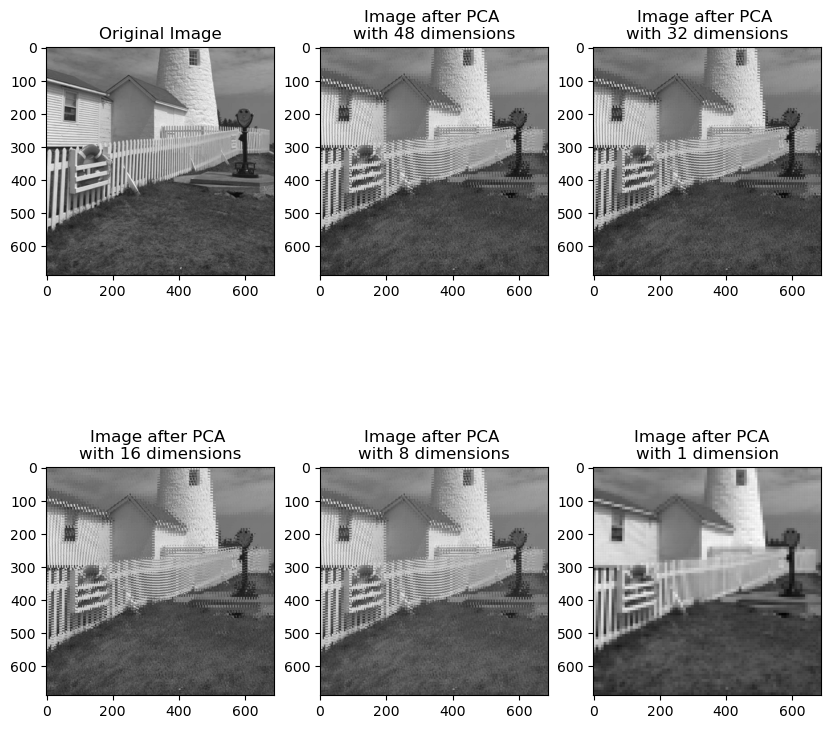

In [6]:
M , N = lighthouse_reduced.shape

plt.figure(figsize = (10,10))
plt.subplot(2 , 3 , 1)
plt.imshow(lighthouse_reduced[ : M - M%8 , : N-N%8]   , cmap = "gray")
plt.title("Original Image")

plt.subplot(2 , 3 , 2)
plt.imshow(image_pca(lighthouse_reduced , 48) , cmap = "gray")
plt.title("Image after PCA \nwith 48 dimensions")

plt.subplot(2 , 3 , 3)
plt.imshow(image_pca(lighthouse_reduced , 32) , cmap = "gray")
plt.title("Image after PCA \nwith 32 dimensions")

plt.subplot(2 , 3 , 4)
plt.imshow(image_pca(lighthouse_reduced , 16) , cmap = "gray")
plt.title("Image after PCA \nwith 16 dimensions")

plt.subplot(2 , 3 , 5)
plt.imshow(image_pca(lighthouse_reduced , 8) , cmap = "gray")
plt.title("Image after PCA \nwith 8 dimensions")

plt.subplot(2 , 3 , 6)
plt.imshow(image_pca(lighthouse_reduced , 1) , cmap = "gray")
plt.title("Image after PCA  \nwith 1 dimension")
plt.show()

##### **2. Discrete Cosine Transform**



Write a program to implement a JPEG-like encoder using the following steps:

Encoder:

1. Divide the image into non-overlapping image blocks of size 8x8.

2. Apply the type-II DCT to each of the blocks.

3. Divide each block by the quantization matrix. Verify that you are left with sparse coefficients.

Decoder:

1. Multiply each block with the inverse Q matrix.

2. Apply the type-II IDCT to each block.

3. Put the sub-blocks together to generatethe decoded estimate of the original image.

Display the original and Lossy-compressed images.

In [7]:
def DCT(img):
    '''
    Performs DCT on the image.

    Parameters
        img: The image to be transformed.

    Returns
        img_dct: The transformed image.
    '''

    M , N = img.shape

    img_dct = np.zeros((M , N) , dtype = np.float64)

    # creating the C matrix
    C = np.ones((M , N))
    C[0 , :] = 1/2**0.5
    C[:, 0] = 1/2**0.5
    C[0 , 0] = 1/2
    
    # taking the DCT
    for u in range(M):
        for v in range(N):
            cos1_matrix = np.array([np.array([((2*i + 1) * u * np.pi / (2 * M)) for j in range(N)]) for i in range(M)])
            try: 
                cos2_matrix = (cos1_matrix * M * v / (N * u)).T
            except:
                # implies u == 0
                cos2_matrix = np.array([np.array([((2*j + 1) * v * np.pi / (2 * N)) for i in range(M)]) for j in range(N)]).T
            img_dct[u , v] = np.sum(img * np.cos(cos1_matrix) * np.cos(cos2_matrix))

    img_dct = img_dct * C * 4 / (M*N)

    return img_dct

In [8]:
def IDCT(img):
    '''
    Performs IDCT on the image.

    Parameters
        img: The image to be transformed.

    Returns
        img_idct: The transformed image.
    '''

    M , N = img.shape

    img_idct = np.zeros((M , N))

    # creating the C matrix
    C = np.ones((M , N) , dtype = np.float64)
    C[0 , :] = 1/2**0.5
    C[:, 0] = 1/2**0.5
    C[0 , 0] = 1/2
    
    # taking the IDCT
    for i in range(M):
        for j in range(N):
            constant1 = 2 * i + 1
            constant2 = 2 * j + 1
            cos_1 = np.array([np.array([constant1 * u * np.pi / (2 * M) for v in range(N)]) for u in range(M)])
            cos_2 = (cos_1 * N * constant2 / (M * constant1)).T

            img_idct[i , j] = np.sum(img * np.cos(cos_1) * np.cos(cos_2) * C) 

    return img_idct

In [9]:
def JPEG_like_encoder(img):
    '''
    Performs JPEG like encoding on the given image.

    Parameters
        img: The image to be encoded.
    
    Returns
        img_encoded: The encoded image.
    '''
    try:
        M , N = img.shape
    except:
        M , N , _ = img.shape
        img = img[: , : , :-1].mean(2)
    
    # cropping the image to have M and N as multiples of 8 for convinience
    M = M - M % 8
    N = N - N % 8

    img_DCT = np.zeros((M , N))
    img_encoded = np.zeros((M , N) , dtype = np.int64)

    QM = np.array(
        [[16,11,10,16,24,40,51,61],
        [12,12,14,19,26,58,60,55],
        [14,13,16,24,40,57,69,56 ],
        [14,17,22,29,51,87,80,62],
        [18,22,37,56,68,109,103,77],
        [24,35,55,64,81,104,113,92],
        [49,64,78,87,103,121,120,101],
        [72,92,95,98,112,100,103,99]]
        )

    
    for j in range(0 , N , 8):
        for i in range(0 , M , 8):
            # taking the DCT of each patch and quantizing it
            patch = np.array(img[i : i + 8 , j : j + 8] ,dtype =np.float64)
            img_DCT[i : i + 8 , j : j + 8] = DCT(patch)
            img_encoded[i : i + 8 , j : j + 8] = (np.divide(img_DCT[i : i + 8 , j : j + 8] , QM) + 0.5).astype(int)

    return img_DCT , img_encoded


In [10]:
def JPEG_like_decoder(img):
    '''
    Performs JPEG like decoding on the given encoded image.

    Parameters
        img: The image to be decoded.
    
    Returns
        img_decoded: The decoded image.
    '''

    M , N = img.shape

    # cropping the image to have M and N as multiples of 8 for convinience
    M = M - M % 8
    N = N - N % 8

    QM = np.array(
    [[16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56 ],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]]
    )
    
    img_decoded = np.zeros((M , N))
    for j in range(0 , N , 8):
        for i in range(0 , M , 8):
            # taking the IDCT of each patch and quantizing it
            patch = np.array(img[i : i + 8 , j : j + 8])
            m = np.multiply(patch , QM)
            img_decoded[i : i + 8 , j : j + 8] = IDCT(m)             

            
    return img_decoded


In [11]:
dct , encoded = JPEG_like_encoder(lighthouse_reduced)

In [12]:
print("The number of zeros in the encoded image is {}, while the total size of the image is {}".\
    format(np.count_nonzero(encoded) , encoded.size))

The number of zeros in the encoded image is 16941, while the total size of the image is 473344


In [13]:
decoded = JPEG_like_decoder(encoded)

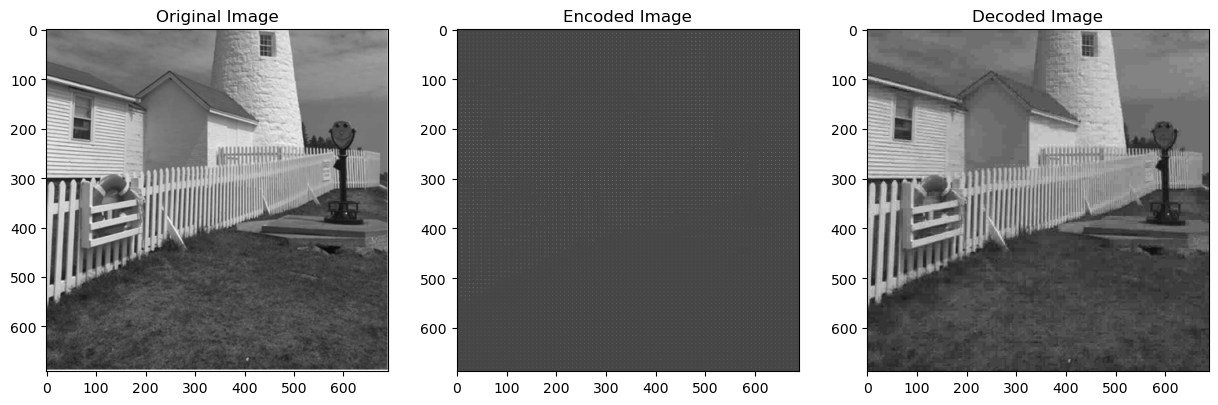

In [14]:
plt.figure(figsize = (15 , 15))
plt.subplot(1 , 3 , 1)
plt.imshow(lighthouse_reduced , cmap = 'gray')
plt.title('Original Image')

plt.subplot(1 , 3 , 2)
plt.imshow(encoded , cmap = 'gray')
plt.title('Encoded Image')

plt.subplot(1 , 3 , 3)
plt.imshow(decoded , cmap = 'gray')
plt.title('Decoded Image')

plt.show()